Run the next code box if you need to install all the dependencies 

In [27]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchData

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

from utils import DatasetSeperation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [29]:
class AutoEncodeur(nn.Module):
    def __init__(self, input_size, encoding_dimension):
        super(AutoEncodeur, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dimension),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dimension, 16),
            nn.ReLU(),
            nn.Linear(16, 24),
            nn.ReLU(),
            nn.Linear(24, input_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [30]:
class TorchDataset(torchData.Dataset):
    def __init__(self, x_array, y_array=None):
        self.x = x_array
        self.y = y_array

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx]).float()
        if self.y is None:
            return x
        y = torch.tensor(self.y[idx]).long()
        return x.to(device), y.to(device)

In [31]:
torchDataset = DatasetSeperation("creditcard.csv")

### Basic setup before preparing data

In [32]:
# == Setting Paths == #
dataset_dir = "dataset"
train_dataset = os.path.join(dataset_dir, "train")
valid_dataset = os.path.join(dataset_dir, "valid")

# == Creating StandarScaler to normalize data == #
scalar = StandardScaler()

### Prepare train data

In [33]:
train_df = pd.read_csv(os.path.join(train_dataset, "train.csv"))

Y_train = train_df.pop("Class")
X_train = train_df

X_scalar_train = scalar.fit_transform(X_train)

### Prepare valid data

In [34]:
valid_df = pd.read_csv(os.path.join(valid_dataset, "valid.csv"))

Y_valid = valid_df.pop("Class")
X_valid = valid_df

X_scalar_valid = scalar.transform(X_valid)

### Generating the TorchDataSet for training

In [35]:
batch_size = 32

train_data = TorchDataset(X_scalar_train, Y_train)
train_loader = torchData.DataLoader(
    train_data, batch_size=batch_size, shuffle=True)
train_N = len(train_loader.dataset)

### Generating the TorchDataSet for validation

In [36]:
valid_data = TorchDataset(X_scalar_valid, Y_valid)
valid_loader = torchData.DataLoader(
    valid_data, batch_size=batch_size, shuffle=True)
valid_N = len(valid_loader.dataset)

### Parameters definition

In [37]:
input_size = len(valid_data[1][0])
encoding_dimension = 8

loss_function = nn.MSELoss()
model = AutoEncodeur(input_size=input_size,
                     encoding_dimension=encoding_dimension)

optimizer = optim.Adam(model.parameters(), lr=0.003)

training

In [38]:
def train(model, check_grad=False):
    loss = 0
    cpt = 0

    model.train()
    for x, y in train_loader:
        cpt += 1
        output = model(x)
        optimizer.zero_grad()
        bacth_loss = loss_function(output, x)
        bacth_loss.backward()
        optimizer.step()

        loss += bacth_loss.item()

    if check_grad:
        print("Last Gradient: ")
        for param in model.parameters():
            print(param.grad)

    print('Train - Loss {:.4f}'.format(loss/cpt))

In [39]:
def validate(model):
    loss = 0
    cpt = 0

    model.eval()
    for x, y in valid_loader:
        cpt += 1
        output = model(x)

        loss += loss_function(output, x)

    print('Valid - Loss {:.4f}'.format(loss/cpt))

In [ ]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(model, check_grad=False)
    validate(model)

In [41]:
model_path = "model"

if not os.path.exists(model_path):
    os.mkdir(model_path)

nom_model = input('Nom du model ?')

torch.save(model, os.path.join(model_path, f"model_{nom_model}.pth"))

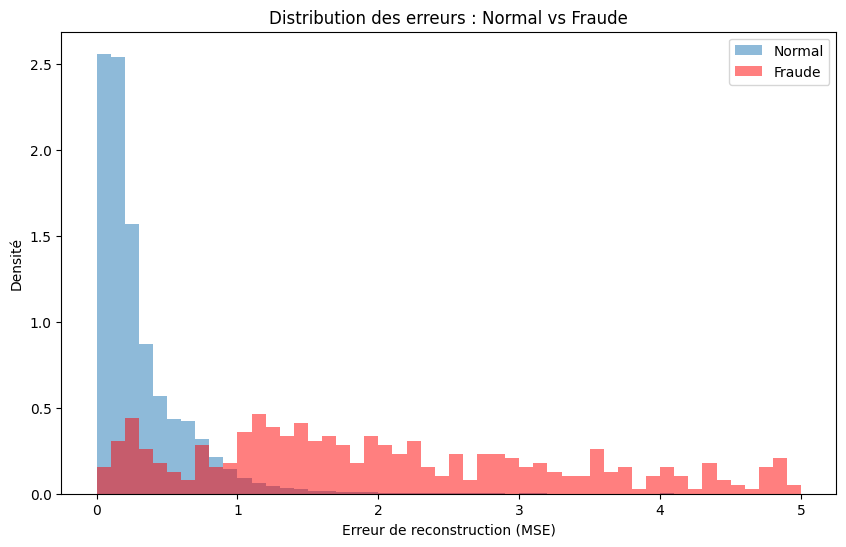

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


name = str(input("Quelle est le nom du model ? "))
model = torch.load(os.path.join(
    model_path, f"model_{name}.pth"), weights_only=False)

model.eval()

reconstruction_errors = []
true_labels = []

with torch.no_grad():
    for x, y in valid_loader:
        output = model(x)

        loss_per_sample = nn.MSELoss(reduction='none')(output, x).mean(dim=1)

        reconstruction_errors.extend(loss_per_sample.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)
true_labels = np.array(true_labels)

errors_normal = reconstruction_errors[true_labels == 0]
errors_fraud = reconstruction_errors[true_labels == 1]

plt.figure(figsize=(10, 6))
plt.hist(errors_normal, bins=50, alpha=0.5,
         label='Normal', density=True, range=(0, 5))
plt.hist(errors_fraud, bins=50, alpha=0.5, label='Fraude',
         color='red', density=True, range=(0, 5))
plt.xlabel('Erreur de reconstruction (MSE)')
plt.ylabel('Densité')
plt.legend()
plt.title('Distribution des erreurs : Normal vs Fraude')
plt.show()

Meilleur seuil trouvé : 2.2083
Meilleur F1-Score : 0.5079


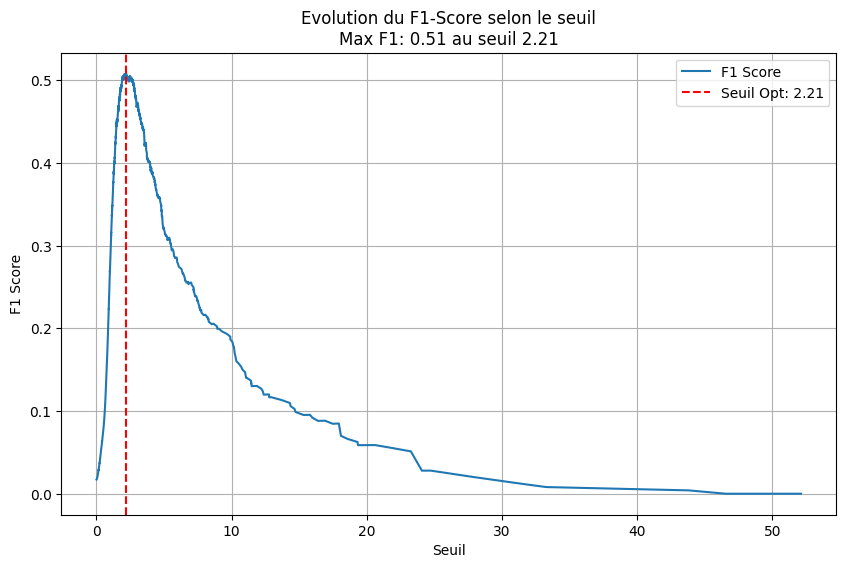


--- Résultats corrigés ---
[[56209   260]
 [  237   255]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56469
      Fraude       0.50      0.52      0.51       492

    accuracy                           0.99     56961
   macro avg       0.75      0.76      0.75     56961
weighted avg       0.99      0.99      0.99     56961



In [42]:
precisions, recalls, thresholds = precision_recall_curve(true_labels, reconstruction_errors)

numerator = 2 * precisions * recalls
denominator = precisions + recalls

f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)

best_idx = np.argmax(f1_scores)

if best_idx >= len(thresholds):
    best_idx = len(thresholds) - 1

best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Meilleur seuil trouvé : {best_threshold:.4f}")
print(f"Meilleur F1-Score : {best_f1:.4f}")

plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Seuil Opt: {best_threshold:.2f}')
plt.title(f"Evolution du F1-Score selon le seuil\nMax F1: {best_f1:.2f} au seuil {best_threshold:.2f}")
plt.xlabel('Seuil')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Résultats corrigés ---")
y_pred_opt = [1 if e > best_threshold else 0 for e in reconstruction_errors]
print(confusion_matrix(true_labels, y_pred_opt))
print(classification_report(true_labels, y_pred_opt, target_names=['Normal', 'Fraude']))